# Tracking test
Perform test for the neuron tracking (identities).  
Inputs are RGB and binary detection frames, and the tracker outputs frames similar to the binary segmentation with a different values for each neuron identity. I.e., 0 is background, 1 is for the pixel of the same neuron through time, 2 is for another neuron, etc.

In [1]:
%matplotlib inline

import os, time, sys
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
from skimage import io, measure
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_common.image import to_npint, imread_to_float

%load_ext autoreload
%autoreload 2

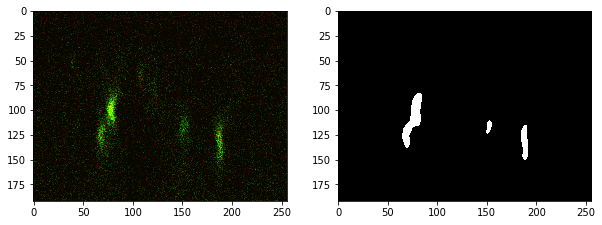

In [2]:
exp = "/data/talabot/pdm/dataset_cv-annotated/train_fail/MDN1-1_image_MDN1_tdTom-GC6s_007/"

rgb_stack = imread_to_float(os.path.join(exp, "RGB.tif"))
seg_stack = io.imread(os.path.join(exp, "seg_ROI.tif")).astype(np.bool)

# Display first frame for visualization
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(rgb_stack[0])
plt.subplot(122)
plt.imshow(seg_stack[0], cmap="gray")
plt.show()

## First tracker
Simply tracker working on consecutive pair of frames.
  1. Link closest neurons
  2. If missing neuron in new frame: do nothing
  3. If supplementary neuron in new frame: do nothing / add new ID

In [3]:
identities = np.zeros(seg_stack.shape, dtype=np.uint8)

start = time.time()
# Initialize with first frame
identities[0] = measure.label(seg_stack[0])
id_max = identities[0].max()

# Loop over following frames
for i in range(1, len(seg_stack)):
    local_labels = measure.label(seg_stack[i])
    new_regions = measure.regionprops(local_labels)
    # Previous regions
    prev_regions = measure.regionprops(identities[i-1])
    
    # Create a cost matrix so that c_ij = cost between new neuron i and old neuron j
    C = cdist([region.centroid for region in prev_regions],
              [region.centroid for region in new_regions])
    
    # Assign identities iteratively by lowest cost (greedy)
    indices_labelled = [] # list of labelled new regions
    for _ in range(len(new_regions)):
        # Verify if all previous neurons have been attributed
        if np.isinf(C).all():
            break
#             for idx in range(C.shape[0]):
#                 if idx in indices_labelled:
#                     continue
#                 identities[i][local_labels == new_regions[idx].label] = id_max + 1
#                 id_max += 1
#             break
        min_prev, min_new = np.unravel_index(np.argmin(C), C.shape)
        identities[i][local_labels == new_regions[min_new].label] = prev_regions[min_prev].label
        # Set costs of linked regions to inf to avoid taking them into account
        C[min_prev,:] = np.inf
        C[:,min_new] = np.inf
        indices_labelled.append(min_new)
print("Identification took %.3f s." % (time.time() - start))

Identification took 0.434 s.


### Visualization
**Note that if they are too many neurons, multiple identities could have the same color!**

In [4]:
id_cmap = matplotlib.cm.get_cmap('Set3')
id_cmap.set_under([0,0,0])

@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg_stack[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=identities.max())
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

3


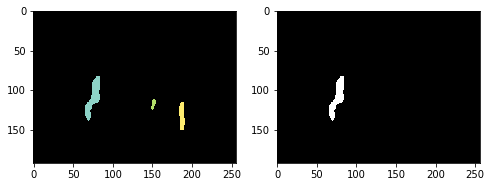

In [7]:
n = 0
print(identities.max())
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(identities[n], cmap=id_cmap, vmin=1, vmax=identities.max())
plt.subplot(122)
plt.imshow(identities[n] == 1, cmap="gray")
plt.show()

## Fluorescence extraction
Extract tdTomato and GCaMP fluorescence traces for each neurons.

Computing traces took 9.025 s.


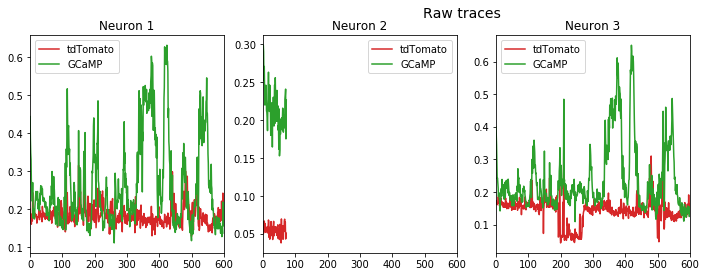

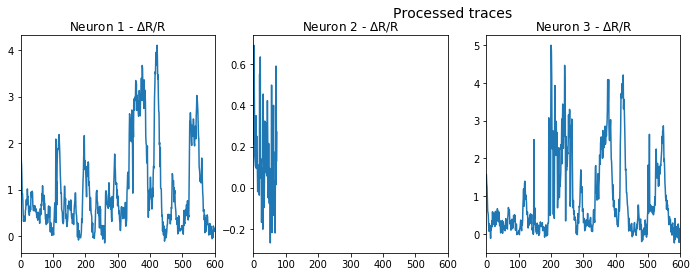

In [10]:
n_frames_0 = 10 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 10:
    print(identities.max(), "different neurons identified, traces are not computed.")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(rgb_stack[...,0][np.logical_not(seg_stack)])
# bkg_g = np.mean(rgb_stack[...,1][np.logical_not(seg_stack)])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        roi = rgb_stack[i,...][identities[i] == j + 1]
        if roi.size > 0:
            traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < bkg: {} < {}). Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
plt.show()